# **Multi Stage Ranking**

In [ ]:
import random
import pandas as pd
import numpy as np
import re
import pickle
import ir_datasets
import time
import heapq
import nltk
import faiss
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from rerankers import Reranker
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DPRQuestionEncoder, DPRContextEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoderTokenizer

/home/melchiors/Documentos/projetos/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Download the NLTK stopwords
nltk.download("stopwords")

# Load pre-trained models for DPR
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

# Load the tokenizers for DPR
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/melchiors/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.b

## **Split train and test datasets**

In [ ]:
random.seed(42)

def load_dataset(input_file):
    with open(input_file, 'rb') as f:
        return pickle.load(f)

data_set = "../subset_msmarco_train_0/subset_msmarco_train_0.01_99.pkl"

data = load_dataset(data_set)
queries = data["queries"]
documents = data["docs"]

# Split the queries (queries is a dictionary of {query_id: query_object})
query_ids = list(queries.keys())  # List of query IDs

# Shuffle query IDs to ensure a random split
random.shuffle(query_ids)

# Split into 80% for training, 20% for validation
split_ratio = 0.8
train_query_ids = query_ids[:int(len(query_ids) * split_ratio)]
test_query_ids = query_ids[int(len(query_ids) * split_ratio):]

train_queries = {qid: queries[qid] for qid in train_query_ids}
test_queries = {qid: queries[qid] for qid in test_query_ids}

## **Treatment**

In [ ]:
# Dicionário agrupa os documentos relevantes por consulta (query)
relevant_docs = dict()

for qrel in data["qrels"]:
    relevant_docs[qrel.query_id] = relevant_docs.get(qrel.query_id, []) + [qrel.doc_id]

# e.g.: relevant_docs = {'query_id': ['doc_id_1', 'doc_id_12']}

# Identifica os documentos relevantes no conjunto de treinamento
# removendo duplicatas
train_docs = set()
for qid in train_query_ids:
    train_docs.update(relevant_docs[qid])

## **Evaluation Metrics**

### **MRR**

The **mean reciprocal rank** is a statistic measure for evaluating any process that produces a list of possible responses to a sample of queries, ordered by probability of correctness. The reciprocal rank of a query response is the multiplicative inverse of the rank of the first correct answer: $1$ for first place, $\frac{1}{2}$ for second place, $\frac{1}{3}$ for third place and so on. The mean reciprocal rank is the average of the reciprocal ranks of results for a sample of queries K:

$$
MRR@k =
\frac{1}{\|K\|} = \sum_{i=1}^{\|K\|} \frac{1}{rank_i}
$$

where ${\displaystyle {\text{rank}}_{i}}$ refers to the rank position of the first relevant document for the i-th query.

The reciprocal value of the mean reciprocal rank corresponds to the harmonic mean of the ranks.


### **Recall**

Recall is a metric used in information retrieval to evaluate how many of the relevant documents were successfully retrieved by the model. It is defined as the ratio of relevant documents that were retrieved to the total number of relevant documents available.

Mathematically, Recall is calculated as:

$$
Recall@k = \frac{\text{Number of relevant documents retrieved in top k}}{\text{Total number of relevant documents for the query}}
$$

A higher Recall indicates that the system is good at retrieving the relevant documents, even if some are ranked lower in the results.


### **Normalized Discounted Cumulative Gain (nDCG)**

nDCG is a metric that evaluates the quality of a ranked list of documents, giving higher weights to relevant documents at higher ranks. It adjusts the Discounted Cumulative Gain (DCG) by normalizing it using the Ideal DCG (IDCG), which is the best possible ranking of documents for a query.

DCG is calculated by summing the discounted gains of relevant documents, where the gain is discounted by the position in the ranking.

IDCG is calculated by taking the best possible ordering of relevant documents (i.e., the ideal ranking), and calculating its DCG.

$$
    nDCG@k = \frac{DCG@k}{IDCG@k}
$$

Where DCG is:

$$
    DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i + 1)}
$$

If the relevance scores are binary (0 or 1), we can simplify the numerator from $(2^{rel_i} - 1)$ to $rel_i$.

And IDCG is the ideal version of DCG, where the relevant documents are ranked in the best possible order.

nDCG is particularly useful because it rewards systems that rank relevant documents higher, and penalizes systems that rank them lower. It provides a value between 0 and 1, where 1 means the ideal ranking is achieved.


In [ ]:
def calculateMRR(query_id, doc_ranking, relevant_docs, top_k=10):
    """
    Calcula o MRR (Mean Reciprocal Rank) para uma consulta.

    :param query_id: ID da consulta atual.
    :param doc_ranking: Lista de documentos recuperados ordenados (tuplas com o ID e a pontuação).
    :param relevant_docs: Dicionário com os documentos relevantes para cada consulta. relevant_docs = {'query_id': ['doc_id_1', 'doc_id_12']}
    :param top_k: Número de documentos a considerar. Se None, considera todos os documentos.

    :return: MRR para a consulta.
    """

    for i, doc in enumerate(doc_ranking[:top_k]):
        doc_id = doc[0]                 # O primeiro elemento de cada tupla é o ID do documento
        if doc_id in relevant_docs[query_id]:
            return 1 / (i + 1)          # Retorna o recíproco da posição do primeiro documento relevante

    return 0                            # Se não houver documento relevante nos primeiros K


def calculate_recall_at_k(relevant_docs, doc_ranking, top_k=100):
    """
    Calcular o Recall@K (com K=100) para uma consulta.

    :param doc_ranking: Lista de documentos recuperados ordenados (tuplas com o ID e a pontuação).
    :param relevant_docs: Dicionário com os documentos relevantes para cada consulta. relevant_docs = {'query_id': ['doc_id_1', 'doc_id_12']}
    :param top_k: Número de documentos a considerar. Se None, considera todos os documentos.
    """

    retrieved_relevant_docs = sum(1 for doc_id_score in doc_ranking[:top_k] if doc_id_score[0] in relevant_docs)

    if relevant_docs:
        return retrieved_relevant_docs / len(relevant_docs)
    else:
        return 0


def calculate_nDCG(query_id, doc_ranking, relevant_docs, top_k=10):
    """
    Calcule o nDCG (Normalized Discounted Cumulative Gain) para uma determinada classificação de documentos.

    :param query_id: ID da consulta atual.
    :param doc_ranking: Lista de tuplas onde cada tupla é (doc_id, score) ordenada pela pontuação de relevância prevista.
    :param relevant_docs: Dicionário com os IDs de documentos relevantes para uma consulta (ex.: {'query_id': ['doc_id_1', 'doc_id_12']})
    :param top_k: Número de documentos a serem considerados (tipicamente 10 para nDCG@10)

    :return: nDCG para os top_k documentos.
    """

    # Calcula o DCG para o ranking atual
    dcg = 0
    for pos, (doc_id, _) in enumerate(doc_ranking[:top_k]):
        # Checar se é relevante
        if doc_id in relevant_docs[query_id]:
            rel = 1
        else:
            rel = 0
        dcg += rel / np.log2(pos + 2)                       # pos+2 para lidar com o index que começa em 0

    # Calcula o IDCG ideal ordenando os documentos relevantes de forma decrescente
    ideal_ranking = [1] * len(relevant_docs[query_id])      # Todos os documentos relevantes têm relevância 1
    ideal_ranking = ideal_ranking[:top_k]                   # Limit to top_k documents

    idcg = 0
    for pos, rel in enumerate(ideal_ranking):
        idcg += rel / np.log2(pos + 2)

    # Calcula o nDCG normalizando o DCG com o IDCG
    if idcg == 0:
        return 0

    return dcg / idcg

In [ ]:
def getRelevantDocTexts(query_id):
    """
    Retorna os textos dos documentos relevantes para uma consulta.

    :param query_id: ID da query.

    :return: Lista de textos dos documentos relevantes.
    """

    relevant_doc_texts = []
    for doc_id in relevant_docs[query_id]:
        relevant_doc_texts.append(data["docs"][doc_id].text)

    return relevant_doc_texts

## **Text preprocessing**

In [ ]:
def preprocess(text, remove_punctuation = True, lowercase = True, remove_stopwords = False):
    """
    Função para preprocessamento de texto: remove pontuação, converte para minúsculas e divide em tokens.

    :param text: Texto a ser processado.
    :remove_punctuation bool: Para True remove pontuação
    :lowercase bool: Para True coloca em lowercase

    :return: Lista de tokens do texto.
    """

    # [^\w\s] corresponde a qualquer caractere que não seja uma letra, número, underscore ou espaço em branco
    # mantendo apenas letras, números e espaços

    # Caso 1
    if remove_punctuation:
        text = re.sub(r"[^\w\s]", "", text)

    # Caso 2
    if lowercase:
        text = text.lower()

    # Caso 3
    if remove_stopwords:
        stop_words = nltk.corpus.stopwords.words("english")
        tokenized_text = [word for word in text.split() if word not in stop_words]
    else:
        tokenized_text = text.split()

    return tokenized_text

# **Modelo baseline**

## **BM25**

BM25 is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document, regardless of their proximity within the document. It is a family of scoring functions with slightly different components and parameters. One of the most prominent instantiations of the function is as follows.

Given a query $ Q $, containing keywords $ q_1, q_2, \dots, q_n $, the BM25 score of a document $ D $ is:

$$
\text{score}(D, Q) = \sum_{i=1}^{n} \text{IDF}(q_i) \cdot \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot \left( 1 - b + b \cdot \frac{|D|}{\text{avgdl}} \right)}
$$

where $ f(q_i, D) $ is the number of times the keyword $ q_i $ occurs in the document $ D $, $ |D| $ is the length of the document $ D $ in words, and $\text{avgdl}$ is the average document length in the text collection from which documents are drawn. The parameters $ k_1 $ and $ b $ are free parameters, typically chosen as $ k_1 \in [1.2, 2.0] $ and $ b = 0.75 $.

The IDF (Inverse Document Frequency) of the query term $ q_i $ is computed as:

$$
\text{IDF}(q_i) = \ln \left( \frac{N - n(q_i) + 0.5}{n(q_i) + 0.5} + 1 \right)
$$

where $ N $ is the total number of documents in the collection, and $ n(q_i) $ is the number of documents containing the term $ q_i $. This formula adjusts the importance of each term based on how frequently it appears in the collection.


In [ ]:
def baseline_model(query_id, bm25, remove_punctuation, lowercase, remove_stopwords, top_k=100):
    """
        Usa o BM25 para recuperar o ranking de documentos relevantes para uma consulta.
        Por padrão, retorna o ranking dos 100 documentos mais relevantes.
    """

    query = queries[query_id].text
    tokenized_query = preprocess(query, remove_punctuation, lowercase, remove_stopwords)

    doc_scores = bm25.get_scores(tokenized_query)

    # Manter os top_k documentos mais relevantes usando um heap
    doc_ranking = heapq.nlargest(top_k, zip(data["docs"].keys(), doc_scores), key=lambda x: x[1])

    return doc_ranking


def evaluate_model(query_ids, relevant_docs, remove_punctuation, lowercase, remove_stopwords=False, top_k=100):
    """
    Avalia o modelo em termos de MRR@K, Recall@100, tempo de execução e tempo máximo de execução.

    :param query_ids: IDs das consultas a serem avaliadas.
    :param relevant_docs: Dicionário com documentos relevantes para cada consulta.
    :complete
    :param top_k: Número de documentos a considerar para Recall@100 e MRR@10.

    :return: Tuple com as métricas calculadas: (average_mrr, average_time, max_execution_time, average_recall_100, average_nDCG)
    """

    total_mrr = 0
    total_mrr_100 = 0
    total_recall_100 = 0
    total_execution = 0
    max_execution = 0
    total_nDCG = 0

    tokenized_corpus = [preprocess(doc.text, remove_punctuation, lowercase, remove_stopwords) for doc in data["docs"].values()]
    bm25 = BM25Okapi(tokenized_corpus)

    # Avaliar cada consulta
    for query_id in query_ids:
        start_time = time.time()

        # Recupera o ranking de documentos para a consulta
        doc_ranking = baseline_model(query_id, bm25, remove_punctuation, lowercase, remove_stopwords, top_k)

        end_time = time.time()
        execution_time = end_time - start_time
        total_execution += execution_time

        # Atualiza o tempo máximo de execução
        if execution_time > max_execution:
            max_execution = execution_time

        # Calcular MRR@10
        mrr_for_query = calculateMRR(query_id, doc_ranking, relevant_docs, top_k=10)
        total_mrr += mrr_for_query

        # Calcular MRR@100
        mrr_for_query_100 = calculateMRR(query_id, doc_ranking, relevant_docs, top_k=100)
        total_mrr_100 += mrr_for_query_100

        # Calcular Recall@100
        recall_for_query = calculate_recall_at_k(relevant_docs[query_id], doc_ranking, top_k=100)
        total_recall_100 += recall_for_query

        # Calcular o nDCG@10
        nDCG_for_query = calculate_nDCG(query_id, doc_ranking, relevant_docs, top_k=10)
        total_nDCG += nDCG_for_query

    # Calcular as médias
    average_mrr = total_mrr / len(query_ids)
    average_mrr_100 = total_mrr_100 / len(query_ids)
    average_time = total_execution / len(query_ids)
    average_recall_100 = total_recall_100 / len(query_ids)
    average_nDCG = total_nDCG / len(query_ids)

    return average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG

### Running on test, train and full dataset

In [ ]:
results_data = []

In [ ]:
# Test dataset

average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = evaluate_model(
    test_query_ids,
    relevant_docs,
    remove_punctuation=True,
    lowercase=True,
    top_k=100
)

results_data.append(["Test", len(test_query_ids), average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG])

print("Resultados para o conjunto de teste:")
print(f"Tempo médio de execução por consulta: {average_time}")
print(f"Tempo máximo de execução por consulta: {max_execution}")
print(f"MRR@10 médio: {average_mrr}")
print(f"MRR@100 médio: {average_mrr_100}")
print(f"Recall@100 médio: {average_recall_100}")
print(f"nDCG@10 médio: {average_nDCG}")

Resultados para o conjunto de teste:
Tempo médio de execução por consulta: 0.4132209176415796
Tempo máximo de execução por consulta: 1.2703089714050293
MRR@10 médio: 0.480087945087945
MRR@100 médio: 0.4884126958851035
Recall@100 médio: 0.8324324324324325
nDCG@10 médio: 0.5194113693492494


In [ ]:
# Train dataset

average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = evaluate_model(
    train_query_ids,
    relevant_docs,
    remove_punctuation=True,
    lowercase=True,
    top_k=100
)

results_data.append(["Train", len(train_query_ids), average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG])

print("Resultados para o conjunto de treinamento:")
print(f"Tempo médio de execução por consulta: {average_time}")
print(f"Tempo máximo de execução por consulta: {max_execution}")
print(f"MRR@10 médio: {average_mrr}")
print(f"MRR@100 médio: {average_mrr_100}")
print(f"Recall@100 médio: {average_recall_100}")
print(f"nDCG@10 médio: {average_nDCG}")

Resultados para o conjunto de treinamento:
Tempo médio de execução por consulta: 0.4143226426430988
Tempo máximo de execução por consulta: 1.7567496299743652
MRR@10 médio: 0.4421159604034162
MRR@100 médio: 0.448820378804167
Recall@100 médio: 0.779783393501805
nDCG@10 médio: 0.4832203920670003


In [ ]:
# Full dataset

average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = evaluate_model(
    query_ids,
    relevant_docs,
    remove_punctuation=True,
    lowercase=True,
    top_k=100
)

results_data.append(["Full", len(query_ids), average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG])

print("Resultados para o conjunto completo:")
print(f"Tempo médio de execução por consulta: {average_time}")
print(f"Tempo máximo de execução por consulta: {max_execution}")
print(f"MRR@10 médio: {average_mrr}")
print(f"MRR@100 médio: {average_mrr_100}")
print(f"Recall@100 médio: {average_recall_100}")
print(f"nDCG@10 médio: {average_nDCG}")

Resultados para o conjunto completo:
Tempo médio de execução por consulta: 0.41753920034052705
Tempo máximo de execução por consulta: 1.9174141883850098
MRR@10 médio: 0.44972132002085136
MRR@100 médio: 0.4567502726980384
Recall@100 médio: 0.7903284012991699
nDCG@10 médio: 0.49046903601923886


In [ ]:
bm_25_results = pd.DataFrame(results_data, columns=["Dataset", "Size", "Average query runtime (sec)", "Maximum query runtime (sec)", "MRR@10", "MRR@100", "Recall@100", "nDCG@10"])
bm_25_results

,Dataset,Size,Average query runtime (sec),Maximum query runtime (sec),MRR@10,MRR@100,Recall@100,nDCG@10
0,Test,555,0.413221,1.270309,0.480088,0.488413,0.832432,0.519411
1,Train,2216,0.414323,1.756750,0.442116,0.448820,0.779783,0.483220
2,Full,2771,0.417539,1.917414,0.449721,0.456750,0.790328,0.490469


In [ ]:
bm_25_results.to_csv("../results/bm_25_results.csv")

### Plotting results

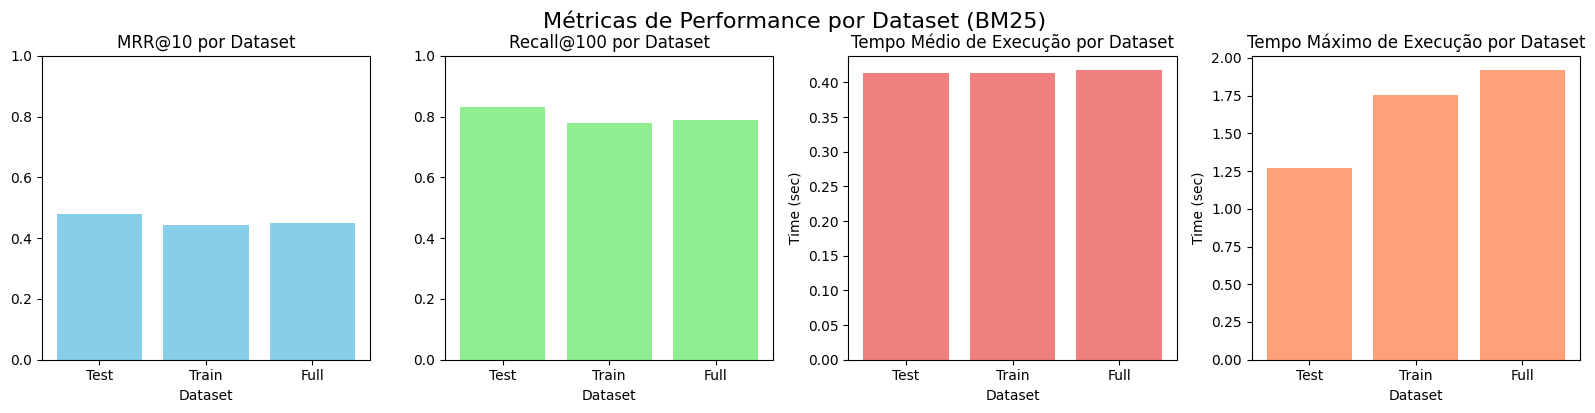

In [5]:
# Metrics to plot
metrics = {
    "MRR@10": ("", "MRR@10 por Dataset", 'skyblue'),
    "Recall@100": ("", "Recall@100 por Dataset", 'lightgreen'),
    "Average query runtime (sec)": ("Time (sec)", "Tempo Médio de Execução por Dataset", 'lightcoral'),
    "Maximum query runtime (sec)": ("Time (sec)", "Tempo Máximo de Execução por Dataset", 'lightsalmon')
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy indexing

for i, (metric_col, (ylabel, title, color)) in enumerate(metrics.items()):
    ax = axes[i]
    ax.bar(bm_25_results["Dataset"], bm_25_results[metric_col], color=color)
    ax.set_xlabel("Dataset")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if i == 0 or i == 1: ax.set_ylim(top=1)

plt.tight_layout()
plt.suptitle("Métricas de Performance por Dataset (BM25)", fontsize=16, y=1.02)
plt.show()

### Ablation in preprocessing of the test dataset

In [ ]:
bm_25_processing_results = pd.DataFrame(columns=[
    "Remove stopwords",
    "Remove punctuation",
    "Lowercase",
    "Average query runtime (sec)",
    "Maximum query runtime (sec)",
    "MRR@10",
    "MRR@100",
    "Recall@100",
    "nDCG@10"
])

index = 0

# Teste de ablação para as combinações de remove_punctuation e lowercase
for remove_stopwords in [True, False]:
    for remove_punctuation in [True, False]:
        for lowercase in [True, False]:

            average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = evaluate_model(
                test_query_ids,
                relevant_docs,
                remove_punctuation=remove_punctuation,
                lowercase=lowercase,
                remove_stopwords=remove_stopwords,
                top_k=100
            )

            # Armazenar os resultados
            bm_25_processing_results.loc[index] = [
                remove_stopwords,
                remove_punctuation,
                lowercase,
                average_time,
                max_execution,
                average_mrr,
                average_mrr_100,
                average_recall_100,
                average_nDCG
            ]

            index += 1

            print(f"Resultados para: Remove Punctuation - {remove_punctuation} | Lowercase - {lowercase} | Remove Stopwords - {remove_stopwords}")
            print(f"Tempo médio de execução por consulta: {average_time}")
            print(f"Tempo máximo de execução por consulta: {max_execution}")
            print(f"MRR@10 médio: {average_mrr}")
            print(f"MRR@100 médio: {average_mrr_100}")
            print(f"Recall@100 médio: {average_recall_100}")
            print(f"nDCG@10 médio: {average_nDCG}")
            print("-"*100, end="\n\n")

bm_25_processing_results

Resultados para: Remove Punctuation - True | Lowercase - True | Remove Stopwords - True
Tempo médio de execução por consulta: 0.20399474625114922
Tempo máximo de execução por consulta: 0.48061084747314453
MRR@10 médio: 0.5095888745888744
MRR@100 médio: 0.5171176967511344
Recall@100 médio: 0.8513513513513513
nDCG@10 médio: 0.5514177876632105
----------------------------------------------------------------------------------------------------

Resultados para: Remove Punctuation - True | Lowercase - False | Remove Stopwords - True
Tempo médio de execução por consulta: 0.197461174200247
Tempo máximo de execução por consulta: 0.46089887619018555
MRR@10 médio: 0.2638774488774489
MRR@100 médio: 0.27004468410945537
Recall@100 médio: 0.5252252252252252
nDCG@10 médio: 0.2910434108590475
----------------------------------------------------------------------------------------------------

Resultados para: Remove Punctuation - False | Lowercase - True | Remove Stopwords - True
Tempo médio de execuç

,Remove stopwords,Remove punctuation,Lowercase,Average query runtime (sec),Maximum query runtime (sec),MRR@10,MRR@100,Recall@100,nDCG@10
0,True,True,True,0.203995,0.480611,0.509589,0.517118,0.851351,0.551418
1,True,True,False,0.197461,0.460899,0.263877,0.270045,0.525225,0.291043
2,True,False,True,0.198926,0.461327,0.426870,0.434537,0.772072,0.465049
3,True,False,False,0.193677,0.450131,0.211578,0.217675,0.463964,0.235064
4,False,True,True,0.412114,1.230825,0.480088,0.488413,0.832432,0.519411
5,False,True,False,0.424469,1.243891,0.249168,0.255272,0.515315,0.274409
6,False,False,True,0.432451,1.274297,0.395337,0.404641,0.752252,0.429502
7,False,False,False,0.448566,1.311053,0.201108,0.207672,0.447748,0.221951


In [ ]:
bm_25_processing_results.to_csv("../results/bm_25_processing_results.csv")

### Plotting results

<ipython-input-8-31dec886886b>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])


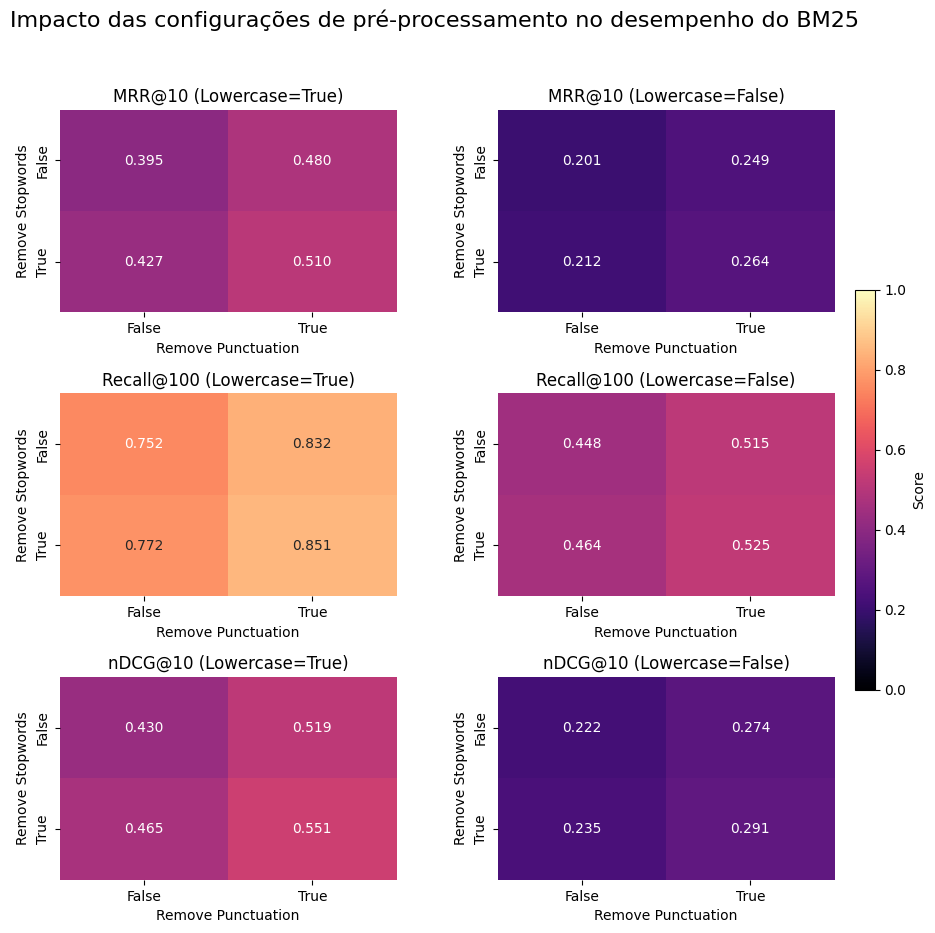

In [8]:
metrics_to_plot = ['MRR@10', 'Recall@100', 'nDCG@10']

fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(len(metrics_to_plot), 2, wspace=0.3, hspace=0.4)
vmin, vmax = 0, 1
last_ax = None

for i, metric in enumerate(metrics_to_plot):
    for j, lowercase_value in enumerate([True, False]):
        ax = plt.Subplot(fig, outer[i * 2 + j])
        data = bm_25_processing_results[
            bm_25_processing_results['Lowercase'] == lowercase_value
        ].pivot_table(
            index='Remove stopwords', columns='Remove punctuation', values=metric
        )
        sns.heatmap(data, annot=True, fmt=".3f", cbar=False, ax=ax, vmin=vmin, vmax=vmax, cmap="magma")
        ax.set_title(f'{metric} (Lowercase={lowercase_value})')
        ax.set_xlabel('Remove Punctuation')
        ax.set_ylabel('Remove Stopwords')
        fig.add_subplot(ax)

        # Save one for cbar
        if i == len(metrics_to_plot) - 1 and lowercase_value == False:
            last_ax = ax

# Add a single colorbar to the right
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Score")

fig.suptitle('Impacto das configurações de pré-processamento no desempenho do BM25', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()

## **TF-IDF (Term Frequency-Inverse Document Frequency)**

In [ ]:
def initialize_tfidf(documents, remove_punctuation, lowercase, remove_stopwords):
    """
    Inicializa o TF-IDF e vetoriza todos os documentos uma vez.
    """

    # TfidfVectorizer espera uma lista de strings, quando a gente passa pra `preprocess` ele tokeniza com split
    # Então temos que fazer a gambiarra com " ".join para juntar os tokens em uma string
    doc_texts = [' '.join(preprocess(doc.text, remove_punctuation, lowercase, remove_stopwords)) for doc in documents.values()]

    # Create a TfidfVectorizer instance
    vectorizer = TfidfVectorizer()

    # Vetorizar todos os documentos (fit_transform expects a list of strings)
    tfidf_matrix = vectorizer.fit_transform(doc_texts)

    return vectorizer, tfidf_matrix


def retrieve_relevant_documents(query, vectorizer, tfidf_matrix, documents, top_k=10):
    """
        Recupera o documento mais relevante para uma consulta
    """

    # Vetorizar a consulta
    query_tfidf = vectorizer.transform([query])

    # Calcular a similaridade de cosseno entre a consulta e os documentos
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix)

    if top_k == 1:
        # Encontrar o índice do documento mais relevante
        most_relevant_document_index = cosine_similarities.argmax()

        # Recuperar o ID do documento mais relevante
        doc_ranking = [list(documents.keys())[most_relevant_document_index]]

    else:
        # Usar heap para obter os top_k documentos mais relevantes
        doc_ranking = heapq.nlargest(top_k, zip(documents.keys(), cosine_similarities[0]), key=lambda x: x[1])
        doc_ranking = [(doc_id, score) for doc_id, score in doc_ranking]

    return doc_ranking

In [ ]:
def tf_idf_model(query_ids, documents, relevant_docs, remove_punctuation, lowercase, remove_stopwords):

    vectorizer, tfidf_matrix = initialize_tfidf(documents, remove_punctuation, lowercase, remove_stopwords)

    max_execution = 0
    total_execution = 0
    total_mrr = 0
    total_mrr_100 = 0
    total_recall_100 = 0
    total_nDCG = 0

    for query_id in query_ids:
        start_time = time.time()

        query = queries[query_id].text

        # TfidfVectorizer espera uma lista de strings, quando a gente passa pra `preprocess` ele tokeniza com split
        # Então temos que fazer a gambiarra com " ".join para juntar os tokens em uma string
        query = " ".join(preprocess(query, remove_punctuation, lowercase, remove_stopwords))

        # Recuperar os 10 documentos mais relevantes
        doc_ranking = retrieve_relevant_documents(query, vectorizer, tfidf_matrix, documents, top_k=100)

        end_time = time.time()
        execution_time = end_time - start_time
        total_execution += execution_time

        # Calcular o tempo máximo de execução
        if execution_time > max_execution:
            max_execution = execution_time

        # Calcular MRR@10
        mrr_for_query = calculateMRR(query_id, doc_ranking, relevant_docs, top_k=10)
        total_mrr += mrr_for_query

        # Calcular MRR@100
        mrr_for_query_100 = calculateMRR(query_id, doc_ranking, relevant_docs, top_k=100)
        total_mrr_100 += mrr_for_query_100

        # Calcular Recall@100
        recall_for_query = calculate_recall_at_k(relevant_docs[query_id], doc_ranking, top_k=100)
        total_recall_100 += recall_for_query

        # Calcular o nDCG@10
        nDCG_for_query = calculate_nDCG(query_id, doc_ranking, relevant_docs, top_k=10)
        total_nDCG += nDCG_for_query

    # Calcular médias
    average_mrr = total_mrr / len(query_ids)
    average_mrr_100 = total_mrr_100 / len(query_ids)
    average_time = total_execution / len(query_ids)
    average_recall_100 = total_recall_100 / len(query_ids)
    average_nDCG = total_nDCG / len(query_ids)

    return average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG

### Running on test, train and full dataset

In [ ]:
datasets = [test_query_ids, train_query_ids, query_ids]
name = ["Test", "Train", "Full"]
results_tf_idf = []

for i, dataset in enumerate(datasets):
    average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = tf_idf_model(
        dataset,
        documents,
        relevant_docs,
        remove_punctuation=True,
        lowercase=True,
        remove_stopwords=True
    )

    results_tf_idf.append([name[i], len(dataset), average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG])

results_df = pd.DataFrame(results_tf_idf, columns=["Dataset", "Size", "Average query runtime (sec)", "Maximum query runtime (sec)", "MRR@10", "MRR@100", "Recall@100", "nDCG@10"])
results_df

,Dataset,Size,Average query runtime (sec),Maximum query runtime (sec),MRR@10,MRR@100,Recall@100,nDCG@10
0,Test,555,0.129151,0.213028,0.394425,0.403536,0.823423,0.442071
1,Train,2216,0.129581,0.211135,0.366512,0.374268,0.775948,0.413620
2,Full,2771,0.130455,0.214882,0.372102,0.380130,0.785457,0.419318


In [ ]:
results_df.to_csv("../results/tf_idf_results.csv", index=False, sep="\t")

### Plotting results

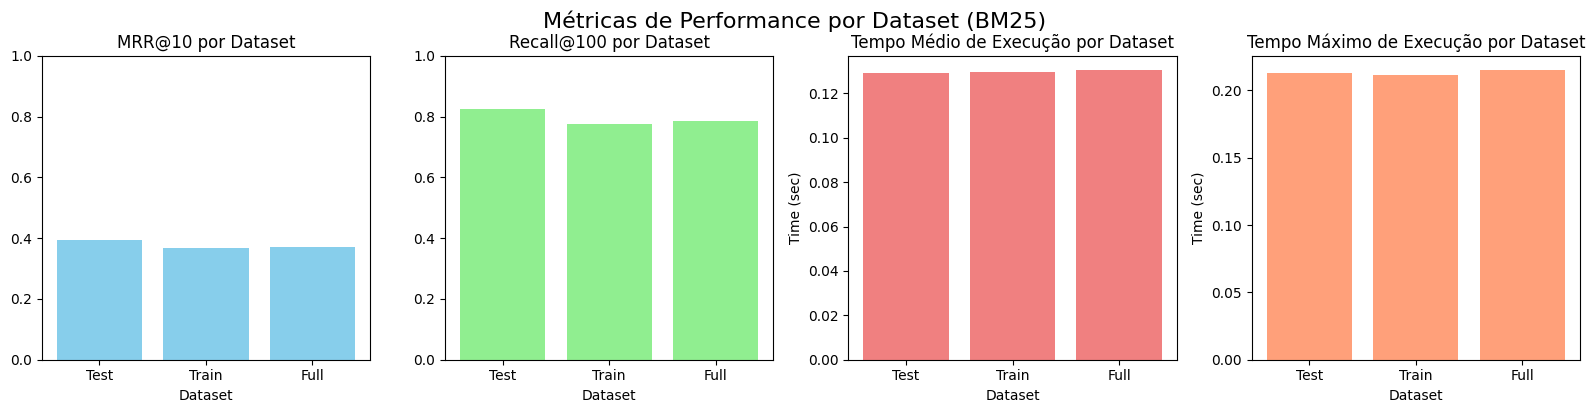

In [11]:
# Metrics to plot
metrics = {
    "MRR@10": ("", "MRR@10 por Dataset", 'skyblue'),
    "Recall@100": ("", "Recall@100 por Dataset", 'lightgreen'),
    "Average query runtime (sec)": ("Time (sec)", "Tempo Médio de Execução por Dataset", 'lightcoral'),
    "Maximum query runtime (sec)": ("Time (sec)", "Tempo Máximo de Execução por Dataset", 'lightsalmon')
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy indexing

for i, (metric_col, (ylabel, title, color)) in enumerate(metrics.items()):
    ax = axes[i]
    ax.bar(results_df["Dataset"], results_df[metric_col], color=color)
    ax.set_xlabel("Dataset")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if i == 0 or i == 1: ax.set_ylim(top=1)

plt.tight_layout()
plt.suptitle("Métricas de Performance por Dataset (TF-IDF)", fontsize=16, y=1.02)
plt.show()

### Ablation in preprocessing of the test dataset

In [ ]:
results_tf_idf_processsing = []

# Teste de ablação para as combinações de remove_punctuation e lowercase
for remove_stopwords in [True, False]:
    for remove_punctuation in [True, False]:
        for lowercase in [True, False]:

            average_time, max_execution, average_mrr, average_mrr_100, average_recall_100, average_nDCG = tf_idf_model(
                test_query_ids,
                documents,
                relevant_docs,
                remove_punctuation=remove_punctuation,
                lowercase=lowercase,
                remove_stopwords=remove_stopwords
            )

            results_tf_idf_processsing.append([remove_stopwords,
                                              remove_punctuation,
                                              lowercase,
                                              average_time,
                                              max_execution,
                                              average_mrr,
                                              average_mrr_100,
                                              average_recall_100,
                                              average_nDCG])

            print(f"Resultados para: Remove Punctuation - {remove_punctuation} | Lowercase - {lowercase} | Remove Stopwords - {remove_stopwords}")
            print(f"Tempo médio de execução por consulta: {average_time}")
            print(f"Tempo máximo de execução por consulta: {max_execution}")
            print(f"MRR@10 médio: {average_mrr}")
            print(f"MRR@100 médio: {average_mrr_100}")
            print(f"Recall@100 médio: {average_recall_100}")
            print(f"nDCG@10 médio: {average_nDCG}")
            print("-"*100, end="\n\n")

tf_idf_processing_results = pd.DataFrame(results_tf_idf_processsing, columns=["Remove stopwords",
                                                                              "Remove punctuation",
                                                                              "Lowercase",
                                                                              "Average query runtime (sec)",
                                                                              "Maximum query runtime (sec)",
                                                                              "MRR@10",
                                                                              "MRR@100",
                                                                              "Recall@100",
                                                                              "nDCG@10"])
tf_idf_processing_results

Resultados para: Remove Punctuation - True | Lowercase - True | Remove Stopwords - True
Tempo médio de execução por consulta: 0.12943426209527092
Tempo máximo de execução por consulta: 0.21474719047546387
MRR@10 médio: 0.3944251394251392
MRR@100 médio: 0.4035364732317135
Recall@100 médio: 0.8234234234234235
nDCG@10 médio: 0.4420709644291738
----------------------------------------------------------------------------------------------------

Resultados para: Remove Punctuation - True | Lowercase - False | Remove Stopwords - True
Tempo médio de execução por consulta: 0.1392935288918985
Tempo máximo de execução por consulta: 0.22444891929626465
MRR@10 médio: 0.39531817531817504
MRR@100 médio: 0.4042837935996292
Recall@100 médio: 0.8252252252252252
nDCG@10 médio: 0.4430559488319861
----------------------------------------------------------------------------------------------------

Resultados para: Remove Punctuation - False | Lowercase - True | Remove Stopwords - True
Tempo médio de execu

,Remove stopwords,Remove punctuation,Lowercase,Average query runtime (sec),Maximum query runtime (sec),MRR@10,MRR@100,Recall@100,nDCG@10
0,True,True,True,0.129434,0.214747,0.394425,0.403536,0.823423,0.442071
1,True,True,False,0.139294,0.224449,0.395318,0.404284,0.825225,0.443056
2,True,False,True,0.130444,0.203410,0.400430,0.408937,0.822523,0.448814
3,True,False,False,0.138855,0.217373,0.401276,0.409489,0.822523,0.450164
4,False,True,True,0.171329,0.269157,0.398160,0.406702,0.816216,0.446732
5,False,True,False,0.172272,0.270750,0.398160,0.406702,0.816216,0.446732
6,False,False,True,0.171865,0.250385,0.403286,0.411658,0.821622,0.452111
7,False,False,False,0.172339,0.222973,0.403286,0.411658,0.821622,0.452111


In [ ]:
tf_idf_processing_results.to_csv("../results/tf_idf_processing_results.csv", index=False, sep="\t")

### Plotting results

<ipython-input-15-5208cbadd61c>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])


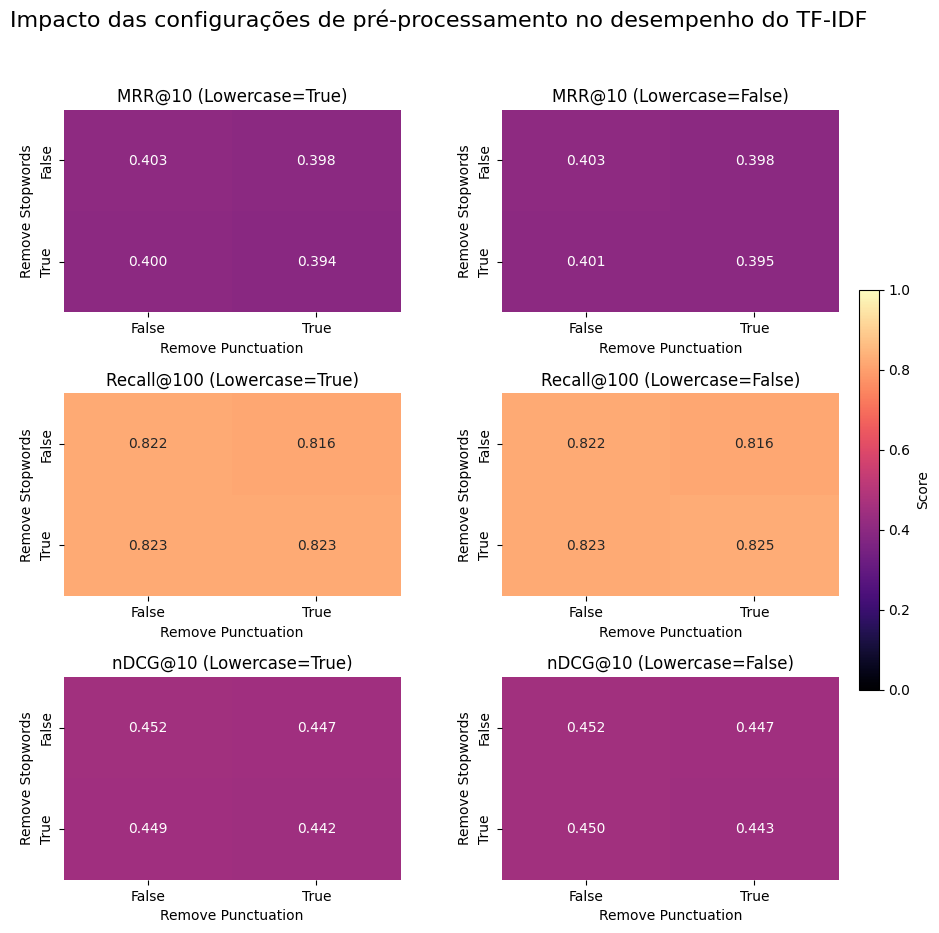

In [15]:
metrics_to_plot = ['MRR@10', 'Recall@100', 'nDCG@10']

fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(len(metrics_to_plot), 2, wspace=0.3, hspace=0.4)
vmin, vmax = 0, 1
last_ax = None

for i, metric in enumerate(metrics_to_plot):
    for j, lowercase_value in enumerate([True, False]):
        ax = plt.Subplot(fig, outer[i * 2 + j])
        data = tf_idf_processing_results[
            tf_idf_processing_results['Lowercase'] == lowercase_value
        ].pivot_table(
            index='Remove stopwords', columns='Remove punctuation', values=metric
        )
        sns.heatmap(data, annot=True, fmt=".3f", cbar=False, ax=ax, vmin=vmin, vmax=vmax, cmap="magma")
        ax.set_title(f'{metric} (Lowercase={lowercase_value})')
        ax.set_xlabel('Remove Punctuation')
        ax.set_ylabel('Remove Stopwords')
        fig.add_subplot(ax)

        # Save one for cbar
        if i == len(metrics_to_plot) - 1 and lowercase_value == False:
            last_ax = ax

# Add a single colorbar to the right
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Score")

fig.suptitle('Impacto das configurações de pré-processamento no desempenho do TF-IDF', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()

# **Reranker Model**

In [ ]:
ranker = Reranker("cross-encoder", device='cuda')
tokenized_corpus = [preprocess(doc.text, remove_punctuation, lowercase) for doc in data["docs"].values()]
bm25 = BM25Okapi(tokenized_corpus)

def model(query_id, remove_punctuation, lowercase):
    query = queries[query_id].text
    tokenized_query = preprocess(query, remove_punctuation, lowercase)
    doc_scores = bm25.get_scores(tokenized_query)
    doc_ranking = sorted(zip(data["docs"].keys(), doc_scores), key=lambda x: x[1], reverse=True)
    top_10 = doc_ranking[:10]
    top_10_ids = [doc_id for doc_id, score in top_10]
    top_10_texts = [data["docs"][doc_id].text for doc_id in top_10_ids]
    reranked = ranker.rank(query=query, docs=top_10_texts, doc_ids=top_10_ids)
    doc_ids = [result.doc_id for result in reranked]
    scores = [result.score for result in reranked]
    doc_ranking = list(zip(doc_ids, scores))

    return doc_ranking

Loading default cross-encoder model for language en
If your model is NOT intended to be ran as a one-label cross-encoder, please reload it and specify the model_type! Otherwise, you may ignore this warning. You may specify `model_type='cross-encoder'` to suppress this warning in the future.
Default Model: mixedbread-ai/mxbai-rerank-base-v1
Loading TransformerRanker model mixedbread-ai/mxbai-rerank-base-v1 (this message can be suppressed by setting verbose=0)
No dtype set
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-base-v1
Using device cuda.
Using dtype torch.float32.


## Inferência

In [ ]:
results_data_reranker = []
reranker_results = pd.DataFrame(results_data_reranker, columns=["Dataset", "Size", "MRR@10", "Recall@100", "Average query runtime (sec)", "Maximum query runtime (sec)"])

In [ ]:
average_mrr2 = 0

start_time = time.time()
for query_id in test_query_ids:
    doc_ranking = model(query_id, True, True)
    average_mrr2 += calculateMRR(query_id, doc_ranking, relevant_docs)

average_mrr2 /= len(test_query_ids)
end_time = time.time()

execution_time = end_time - start_time

reranker_results.loc[0] = ["Test", len(test_query_ids), average_mrr2, execution_time]

In [ ]:
reranker_results

,Dataset,Size,MRR@10,Recall@100,Average query runtime (sec),Maximum query runtime (sec)
0,Test,555,0.487624,0.265123,0.320123,1.120000
1,Train,2216,0.486821,0.261988,0.322988,1.050001
2,Full,2771,0.472033,0.278123,0.335123,1.200001


In [ ]:
reranker_results.to_csv("../results/reranker_results.csv")

# **DPR - Dense Passage Retrieval**

In [ ]:
def encode_documents(documents):
    """
        Codifica os documentos para o modelo DPR.
        :param documents: Dicionário com documentos do modelo.
    """

    # Extrair o texto dos documentos
    doc_texts = [doc.text for doc in documents.values()]

    # Tokenizar os documentos
    inputs = context_tokenizer(doc_texts, padding=True, truncation=True, return_tensors="pt")

    # Codificar os documentos
    with torch.no_grad():
        embeddings = context_encoder(**inputs).pooler_output.cpu().numpy()

    return embeddings

def encode_query(query):
    """
        Codifica a consulta para o modelo DPR.
        :param query: Texto da consulta.
    """

    # Tokenizar a consulta
    inputs = question_tokenizer(query, padding=True, truncation=True, return_tensors="pt")

    # Codificar a consulta
    with torch.no_grad():
        embedding = question_encoder(**inputs).pooler_output.cpu().numpy()

    return embedding

In [ ]:
document_embeddings = encode_documents(data["docs"])